In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [0]:
np.random.seed(101)
tf.set_random_seed(101)

## Dataset
** Alternative sources of the data just in case: **

* http://yann.lecun.com/exdb/mnist/
* https://github.com/mrgloom/MNIST-dataset-in-different-formats

In [3]:
from keras.datasets import mnist

(X, y), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print('')
print(X_val.shape)
print(y_val.shape)
print('')
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(48000, 28, 28)
(48000,)

(12000, 28, 28)
(12000,)

(10000, 28, 28)
(10000,)


In [4]:
# not normalized
print(X_train[0].max())
print(X_train[0].min())

255
0


5


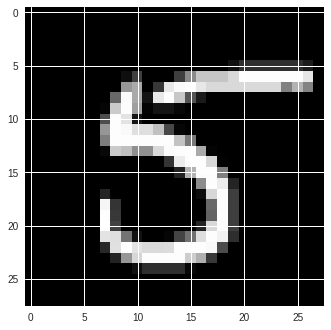

In [5]:
plt.imshow(X_train[0], cmap='gray');
print(y_train[0])

## Feature Engineering

In [6]:
# Normalize X [0 - 1]
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Reshape tensor
X_train_rs = X_train_norm.reshape(-1, 28, 28, 1)
X_val_rs = X_val_norm.reshape(-1, 28, 28, 1)
X_test_rs = X_test_norm.reshape(-1, 28, 28, 1)

print(X_train_rs.shape)
print(X_val_rs.shape)
print(X_test_rs.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
# One hot encoding y
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print(y_train_cat.shape)
print(y_val_cat.shape)
print(y_test_cat.shape)

(48000, 10)
(12000, 10)
(10000, 10)


## Model - Keras

In [8]:
# Equivalent Keras Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Activation, Dropout
import keras.backend as K

K.clear_session()

model = Sequential()

# Feature Extraction layers
model.add(Conv2D(32, (6, 6), input_shape=(28, 28, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(64, (6, 6), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Activation('relu'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3212288   
__________

## Model - Tensorflow

In [0]:
tf.reset_default_graph()

In [0]:
def init_weights(shape):
    """Init weight"""
    # Random normal distribution
    init_random_dist = tf.truncated_normal(
        shape, 
        stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    """Init bias"""
    # Constant 0.1
    init_bias_vals = tf.constant(
        0.1,
        shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
def conv2d(x, W):
    # x tensor: [batch, H, W, C]
    # W tensor: [filter H, filter W, Cin, Cout]
    return tf.nn.conv2d(
        x, W,
        strides=[1, 1, 1, 1], 
        padding='SAME')


def conv_layer(x, shape):
    # [filter H, filter W, Cin, Cout]
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(x, W) + b)


def max_pool_2by2_layer(x):
    # tensor x: [batch, H, W, C]
    return tf.nn.max_pool(
        x, 
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='SAME')


def dense_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [12]:
# Placeholders
X_ph = tf.placeholder(tf.float32,shape=[None,28,28,1])
y_ph = tf.placeholder(tf.float32,shape=[None,10])
dropout_ph = tf.placeholder(tf.float32) # Dropout params

###################################### Stack layers ###############################################
# Feature Extraction layers
convo_1 = conv_layer(
    X_ph,
    shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2_layer(convo_1)

convo_2 = conv_layer(
    convo_1_pooling,
    shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2_layer(convo_2)

# Flatten layer
convo_2_flat = tf.reshape(convo_2_pooling,[-1, 7*7*64])

# Fully connected layers
dense_layer_one = tf.nn.relu(
    dense_layer(convo_2_flat, 1024))

dense_one_dropout = tf.nn.dropout(
    dense_layer_one,
    keep_prob=dropout_ph)

y_pred = dense_layer(dense_one_dropout, 10)
###################################################################################################

# Loss function
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_ph,
        logits=y_pred))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

# trainning function
train = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def next_batch(X, y, batch_size=10):
    # Select a random batch index
    rand_idx = np.random.randint(
        len(X),
        size=batch_size)

    return X[rand_idx], y[rand_idx]

In [14]:
# Init Variables
init = tf.global_variables_initializer()

# GPU option
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# Saver
saver = tf.train.Saver()

# Epochs
epochs = 4001

# Accuracies
train_accs = []
val_accs = []

# Losses
train_losses = []
val_losses = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # Init Variables
    sess.run(init)
    
    # Run epochs
    for i in range(epochs):
        # Select a random batch
        X_batch , y_batch = next_batch(
            X_train_rs , y_train_cat,
            batch_size=100)

        # Train
        sess.run(
            train,
            feed_dict={
                X_ph: X_batch,
                y_ph: y_batch,
                dropout_ph: 0.5})
        
        if i%100 == 0:
            # Train acc
            train_matches = tf.equal(
                tf.argmax(y_batch, 1),
                tf.argmax(y_pred, 1))

            train_accuracy = tf.reduce_mean(tf.cast(train_matches,tf.float32))

            train_acc = sess.run(
                train_accuracy,
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch,
                    dropout_ph:1.0})

            train_accs.append(train_acc)
            
            # Train loss
            train_loss = loss.eval(
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch,
                    dropout_ph: 1.0})
            train_losses.append(train_loss)
            
            # Val acc
            val_matches = tf.equal(
                tf.argmax(y_val_cat, 1),
                tf.argmax(y_pred, 1))

            val_accuracy = tf.reduce_mean(tf.cast(val_matches,tf.float32))

            val_acc = sess.run(
                val_accuracy,
                feed_dict={
                    X_ph: X_val_rs,
                    y_ph: y_val_cat,
                    dropout_ph: 1.0})

            val_accs.append(val_acc)
            
            # Val loss
            val_loss = loss.eval(
                feed_dict={
                    X_ph: X_val_rs,
                    y_ph: y_val_cat,
                    dropout_ph: 1.0})
            val_losses.append(val_loss)

            # PRINT OUT A MESSAGE EVERY 500 STEPS
            if i%500 == 0:
                print('Epoch {}'.format(i))
                print('train_acc = {} - val_acc = {}'.format(train_acc, val_acc))
                print('train_loss = {} - val_loss = {}\n'.format(train_loss, val_loss))

    # SAVE MODEL
    saver.save(sess, 'my_model/MNIST_CNN.ckpt')

Epoch 0
train_acc = 0.07000000029802322 - val_acc = 0.05483333393931389
train_loss = 5.779883861541748 - val_loss = 5.835087299346924

Epoch 500
train_acc = 0.9800000190734863 - val_acc = 0.9505833387374878
train_loss = 0.12986335158348083 - val_loss = 0.1569656878709793

Epoch 1000
train_acc = 1.0 - val_acc = 0.9679166674613953
train_loss = 0.03042956441640854 - val_loss = 0.1047934740781784

Epoch 1500
train_acc = 0.9800000190734863 - val_acc = 0.9752500057220459
train_loss = 0.06847436726093292 - val_loss = 0.08122622966766357

Epoch 2000
train_acc = 0.9800000190734863 - val_acc = 0.9797499775886536
train_loss = 0.05218138173222542 - val_loss = 0.06874178349971771

Epoch 2500
train_acc = 1.0 - val_acc = 0.9805833101272583
train_loss = 0.027216320857405663 - val_loss = 0.0621066577732563

Epoch 3000
train_acc = 1.0 - val_acc = 0.9830833077430725
train_loss = 0.01049396488815546 - val_loss = 0.05580705404281616

Epoch 3500
train_acc = 0.9900000095367432 - val_acc = 0.984416663646698
t

Text(0.5,0,'Epochs')

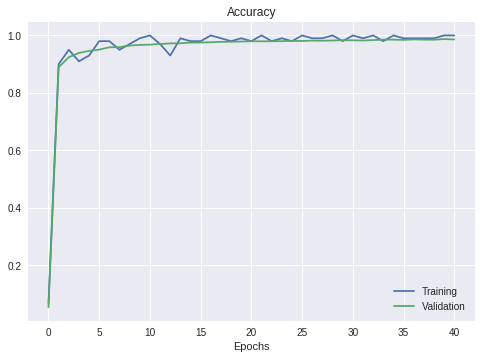

In [15]:
plt.plot(train_accs)
plt.plot(val_accs)

plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

Text(0.5,0,'Epochs')

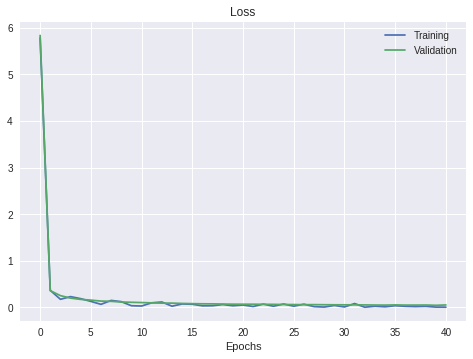

In [16]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epochs')

## Evaluate Test

In [17]:
with tf.Session() as sess:
    # Restore the model
    saver.restore(sess,'my_model/MNIST_CNN.ckpt')
    
    # Test accuracy
    test_matches = tf.equal(
        tf.argmax(y_test_cat, 1),
        tf.argmax(y_pred, 1))

    test_accuracy = tf.reduce_mean(tf.cast(test_matches,tf.float32))

    test_acc = sess.run(
        test_accuracy,
        feed_dict={
            X_ph: X_test_rs,
            y_ph: y_test_cat,
            dropout_ph:1.0})

    print('Test set accuracy: ', test_acc)

INFO:tensorflow:Restoring parameters from my_model/MNIST_CNN.ckpt
Test set accuracy:  0.9872
